## Data Analysis Flytracking

#### Tracking Program Single Fly Tracker

Data is exported to an CSV file


In [1]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import pandas as pd 

%matplotlib notebook

### Selecting data set file 
- Import Columns: Frames, Seconds , x and y positions and LED
- Convert Frames to secods
- Select onset stim 

In [2]:
#Opening the data set file

#when run more than one time says list command is not applyable
from csv import reader
num_files = 20
flymotion_all = []
for i in range(num_files):
    folder_name = 'data_sens37_unamp/'
    file_name = '100718_Sens37_unamp_'+str(i+1)+'_fly0.csv'
    file = open(folder_name+file_name)
    read_file = reader(file)
    flymotion_all.append(list(read_file
                             ))

In [3]:
# analysis on one file
folder_name = 'data_sens37_unamp/'
file_name = '100718_Sens37_unamp_15_fly0.csv'
file1 = open(folder_name+file_name)
read_file1 = list(reader(file1))

In [4]:
# Data treatment 
def data_treatment(file):
    '''
    Select only columns: frames, time, x and y coordinates, and LED_lum and transform data into np_array
    Returns:1) data_array containing frames, time, x and y coordinates 
            2) LED_lum column
    '''
    fm_data = file[4:]  #Exclude first 4 rows containing unnecessary information
    fm_data_array = np.array(fm_data)  #transform data into np array
    data_array = fm_data_array[:, 0:4]  #select only frames,seconds and x,y position
    LED_lum = fm_data_array[1:,8].astype(np.float)  #Select the LED colmumn to know where is the Red Light Stim
    return data_array, LED_lum

def frame_to_time(data_array, framerate=30.):
    frames = (data_array[1:, 0]).astype(np.float)   #transform array into float
    timepoints = frames/framerate
    return frames, timepoints

def LED_ON(LED_lum, frames, timepoints):
    '''
    Inform when stimulus is on with LED lum. change
    '''
    LED_diff = np.diff(LED_lum) 
    timepoints_LED = timepoints[1:]
    frames_LED = frames[1:]
    crimson_stim_time = timepoints_LED[np.greater(np.abs(LED_diff), 2.)] #look for the place where LED lum changed
    crimson_stim_frame = (frames_LED[np.greater(np.abs(LED_diff), 2.)]).astype(int)
    return crimson_stim_time, crimson_stim_frame

def pixel_per_mm(file):
    '''
    Calculate pixel per mm using arena size 
    '''
    arena_size_pixel = file[2][1]  #retrieve from excel the size of the arena in pixels
    arena_size_mm = 54
    ppm = int(arena_size_pixel) / int(arena_size_mm)  #pixel per mm
    return ppm  

def calculate_dist(data_array, ppm):
    x_coordinates = ((data_array[1:, 2]).astype(np.float))/ppm   #transform coordinates in pixels into mm
    y_coordinates = ((data_array[1:, 3]).astype(np.float))/ppm
    positions_array = np.vstack((x_coordinates, y_coordinates))
    distance_between_frames = np.sqrt(np.sum((np.diff(positions_array))**2, axis=0))
    cumulative_distance = np.cumsum(distance_between_frames)
    return x_coordinates, y_coordinates, positions_array,distance_between_frames, cumulative_distance

def calculate_velocity(distance_between_frames, framerate=30.):
    velocity = np.divide(distance_between_frames, (1/framerate))
    nvel = velocity.shape[0]
    return velocity


def stimulus_on_off_sec(LED_lum, frames, timepoints):
    crimson_stim_time, crimson_stim_frame = LED_ON(LED_lum, frames, timepoints)    
    stim_onset_frame =  crimson_stim_frame[0]
    stim_offset_frame = crimson_stim_frame[1]
    
    # analyse only a section of the total frames of 30 frames before crim. onset and 120 frames after crim. onset
    # set starting and point for plots
    start_point = stim_onset_frame - 30
    end_point = stim_onset_frame + 120
    return start_point, end_point

In [5]:
file = read_file1.copy()
data_array, LED_lum = data_treatment(file)
frames, timepoints = frame_to_time(data_array)
LED_diff = np.diff(LED_lum) 
timepoints_LED = timepoints[1:]
frames_LED = frames[1:]
crimson_stim_time = timepoints_LED[np.greater(np.abs(LED_diff), 2.)] #look for the place where LED lum changed 
crimson_stim_frame = (frames_LED[np.greater(np.abs(LED_diff), 2.)]).astype(int)
start_point, end_point = stimulus_on_off_sec(LED_lum, frames, timepoints)

### Plot Trajectories

(120,)
(417,)


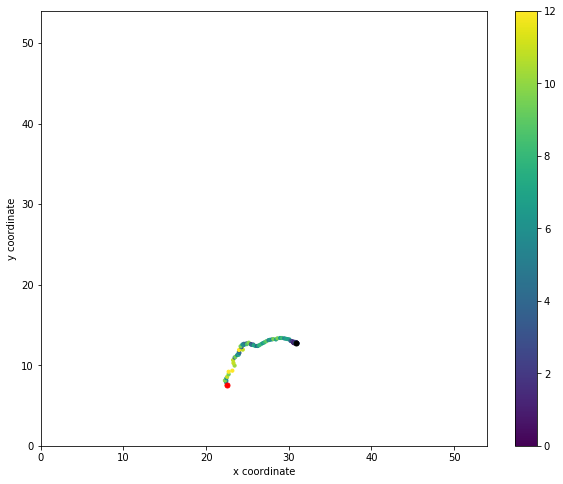

<Figure size 432x288 with 0 Axes>

In [18]:
#Plot Trajectories
def plot_traject_vel(file):
    data_array, LED_lum = data_treatment(file)
    ppm = pixel_per_mm(file)
    frames, timepoints = frame_to_time(data_array)
    x_coordinates, y_coordinates, positions_array, distance_between_frames, cumulative_distance = calculate_dist(
        data_array, ppm)
   
    start_point, end_point = stimulus_on_off_sec(LED_lum, frames, timepoints)
    stim_time = start_point +30
    x_coord_cut = x_coordinates[stim_time:end_point]
    y_coord_cut = y_coordinates[stim_time:end_point]
    
    
    # Calculate velocities
    velocity = calculate_velocity(distance_between_frames, framerate=30.)
    velocity_short = velocity[stim_time:end_point]
    print (velocity_short.shape)
   

    print (x_coordinates.shape)
    #circle1 = plt.Circle((27, 27), 27,color='grey',alpha=0.05)
    fig, ax1  = plt.subplots(1, figsize=(10, 8))
    sc = ax1.scatter(x_coord_cut, y_coord_cut, c=velocity_short, cmap=plt.cm.viridis,alpha=1, s=10,vmin=0,vmax=12)
    ax1.plot(x_coord_cut[0], y_coord_cut[0], 'o', ms=5, color='r')
    ax1.plot(x_coord_cut[-1], y_coord_cut[-1], 'o', ms=5, color='k')
    ax1.set_xlim(0,54)
    ax1.set_ylim(0,54)
    ax1.set_xlabel('x coordinate')
    ax1.set_ylabel('y coordinate')
    #ax1.add_artist(circle1)

    plt.colorbar(sc)
    plt.show()


plot_traject_vel(read_file1)
plt.savefig('Sens37_unamp_trajectory1.svg')

## Analysis on all the data files

In [19]:
#Opening the data set file
# from csv import reader
num_files = 19
# flymotion_all = []
velocity_all = []
cum_distance_all = []
for i in range(num_files):
    folder_name = 'data_sens37_unamp/'
    file_name = '100718_Sens37_unamp_' + str(i+1) + '_fly0.csv'
    file = open(folder_name+file_name)
    read_file = list(reader(file))
    # preprocessing on the read_file
    data_array, LED_lum = data_treatment(read_file)
    ppm = pixel_per_mm(read_file)
    frames, timepoints = frame_to_time(data_array)
    x_coordinates, y_coordinates, positions_array, distance_between_frames, cumulative_distance = calculate_dist(
        data_array, ppm)
    start_point, end_point = stimulus_on_off_sec(LED_lum, frames, timepoints)
    velocity = calculate_velocity(distance_between_frames, framerate=30.)#velocity values for each frame
    velocity_croped = velocity[start_point:end_point] # we cut the velocity values 1 seconds before the stim and 4 seconds after
    velocity_all.append(velocity_croped)
    
    cum_dist = cumulative_distance[start_point:end_point]
    cum_dist_zero = cum_dist -(cumulative_distance[start_point])     #alteration 11/19 start the sum 1 sec before stim
    cum_distance_all.append(cum_dist_zero)

In [20]:
# function to compute confidence interval (ci)
# here 95% confidence interval
def ci_wp(a, axis=0):
    """calculate confidence interval using Wikipedia's formula"""
    m = np.mean(a, axis=axis)
    p = a.shape[0]
    s = 1.96*np.std(a)/np.sqrt(p)
    return m - s, m + s

In [21]:
# concatenate the analysis for all files into numpy array and compute mean and std
velocity_conc = np.vstack([velocity_all[i]] for i in range(num_files))
mean_velocity = np.mean(velocity_conc, axis=0)
std_velocity = np.std(velocity_conc, axis=0)
sem_velocity = std_velocity/math.sqrt(num_files)
ci_lower_velocity, ci_upper_velocity = ci_wp(velocity_conc, axis=0)

# similar analysis for cumulative distance
dist_conc = np.vstack([cum_distance_all[i]] for i in range(num_files))
mean_dist = np.mean(dist_conc, axis=0)
std_dist = np.std(dist_conc, axis=0)
ci_lower_dist, ci_upper_dist = ci_wp(dist_conc, axis=0)


In [22]:
# create a long-form dataframe for speed and distance
framerate=30
v = np.concatenate([velocity_all[i] for i in range(num_files)])
t = np.tile(np.linspace(-1, 4, mean_velocity.size)+(1/framerate), num_files)
d = np.concatenate([cum_distance_all[i] for i in range(num_files)])
df1 = pd.DataFrame({'Speed': v,'Time': t,'Distance':d})

## Velocity plots

## Plot of the mean velocity with standard error of the mean: Plots for Figure 1

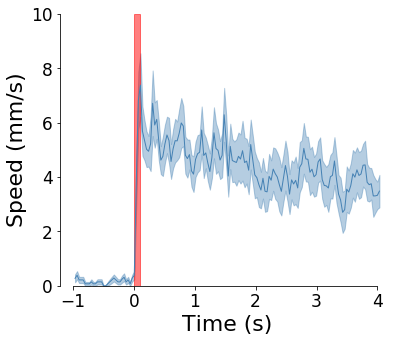

In [23]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(np.linspace(-1, 4, mean_velocity.size)+(1/framerate), mean_velocity, color='SteelBlue', alpha=1, lw=1)
ax.fill_between(np.linspace(-1, 4, mean_velocity.size)+(1/framerate), mean_velocity+sem_velocity, mean_velocity-sem_velocity,
                alpha=0.4, color='SteelBlue')
ax.axvspan(0, 0.1, alpha=0.5, color='red')
ax.set_ylim([0, 10])
plt.tick_params(labelsize=17) 
plt.xlabel('Time (s)',fontsize=22)
plt.ylabel('Speed (mm/s)',fontsize=22)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_bounds(0, 10)
ax.spines['bottom'].set_bounds(-1, 4)
#plt.title('Mechanosensory Bristles Unamputated',fontsize=22)
plt.savefig('NewMSBristles_unamp_velocity.svg')
#plt.savefig('MSBristles_unamp_velocity.png')
plt.show()




## Cumulative distance plots

## cumulative distance mean and sem

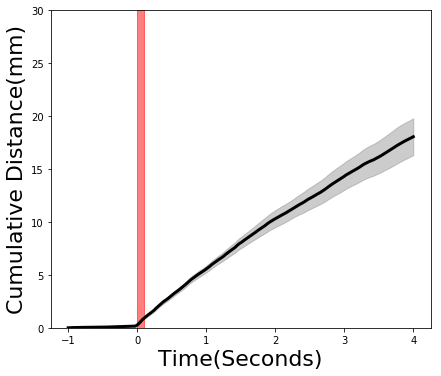

In [24]:
sem_dist = std_dist/math.sqrt(num_files)
fig, ax = plt.subplots(figsize=(6, 5))
fig.tight_layout()
ax.plot(np.linspace(-1, 4, mean_dist.size), mean_dist, color='black', alpha=1, lw=3)
ax.fill_between(np.linspace(-1, 4, mean_dist.size), mean_dist-sem_dist, mean_dist+sem_dist, 
                alpha=0.4, color='grey')
ax.axvspan(0, 0.1, alpha=0.5, color='red')
ax.set_xlabel('Time(Seconds)',fontsize = 22)
ax.set_ylabel('Cumulative Distance(mm)',fontsize = 22)
plt.savefig('Sens37_unamp_dist.svg')
ax.set_ylim([0,30])
plt.show()


